In [1]:
import pyspark 
from pyspark.context import SparkContext
from pyspark.sql import HiveContext
from pyspark.sql import SparkSession

sc = SparkContext('local', 'pyspark')
sqlContext = HiveContext(sc)
spark = SparkSession.builder.getOrCreate()



In [2]:

movies = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('movies_1.csv')
movies.take(5)

[Row(movieId='1', title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId='2', title='Jumanji (1995)', genres='Adventure|Children|Fantasy'),
 Row(movieId='3', title='Grumpier Old Men (1995)', genres='Comedy|Romance'),
 Row(movieId='4', title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance'),
 Row(movieId='5', title='Father of the Bride Part II (1995)', genres='Comedy')]

In [3]:
ratings = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load('ratings_1.csv')
ratings.take(5)

[Row(userId='1', movieId='1', rating='4.0', timestamp='964982703'),
 Row(userId='1', movieId='3', rating='4.0', timestamp='964981247'),
 Row(userId='1', movieId='6', rating='4.0', timestamp='964982224'),
 Row(userId='1', movieId='47', rating='5.0', timestamp='964983815'),
 Row(userId='1', movieId='50', rating='5.0', timestamp='964982931')]

In [5]:
print (spark.version)

2.4.3


In [6]:

print ("Numero de particiones para el DataFrame de peliculas: " + str(movies.rdd.getNumPartitions()))
print ("Numero de particiones para el DataFrame de ratings: " + str(ratings.rdd.getNumPartitions()))



Number of partitions for the movies DataFrame: 1
Number of partitions for the ratings DataFrame: 1


In [7]:
repartitionedRatings = ratings.repartition(10)
print ("Numero de particiones para el DataFrame de ratings: " + str(ratings.rdd.getNumPartitions()))
print ("Numero de particiones para el DataFrame de particiones repartidas: " + str(repartitionedRatings.rdd.getNumPartitions()))


Number of partitions for the ratings DataFrame: 1
Number of partitions for the repartitionedRatings DataFrame: 10


In [8]:
print ("Numero de ratings: " + str(repartitionedRatings.count()))

Number of ratings: 100836


In [9]:
repartitionedRatings.cache()

DataFrame[userId: string, movieId: string, rating: string, timestamp: string]

In [10]:
print ("Numero de ratings: " + str(repartitionedRatings.count()))

Number of ratings: 100836


In [10]:

movies.show(truncate=False)



+-------+-------------------------------------+-------------------------------------------+
|movieId|title                                |genres                                     |
+-------+-------------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                     |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                       |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)              |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)             |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)   |Comedy                                     |
|6      |Heat (1995)                          |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                       |Comedy|Romance                             |
|8      |Tom and Huck (1995)                  |Adventure|Children               

In [11]:
movies.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [12]:
movies_file_name = 'movies_1.csv'
ratings_file_name = 'ratings_1.csv'

movies = spark.read.csv(movies_file_name, header=True, inferSchema=True).repartition(10).cache()
ratings = spark.read.csv(ratings_file_name, header=True, inferSchema=True).repartition(10).cache()

In [13]:


movies.printSchema()
ratings.printSchema()



root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [14]:
ratings.describe().show()

+-------+------------------+----------------+------------------+--------------------+
|summary|            userId|         movieId|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914634999|35530.9871987002|1.0425292390606344| 2.162610359951315E8|
|    min|                 1|               1|               0.5|           828124615|
|    max|               610|          193609|               5.0|          1537799250|
+-------+------------------+----------------+------------------+--------------------+



In [17]:


print ("Numero de usuarios diferentes: " + str(ratings.select('userId').distinct().count()))
print ("Number de peliculas diferentes: " + str(ratings.select('movieId').distinct().count()))
print ("Numero de peliculas con al menos una calificacion estrictamente superior a 4: " + str(ratings.filter('rating > 4').select('movieId').distinct().count()))



Number of different users: 610
Number of different movies: 9724
Number of movies with at least one rating strictly higher than 4: 4056


In [18]:
ratings.createOrReplaceTempView('ratings')
spark.sql("SELECT COUNT(DISTINCT(movieId)) AS nb FROM ratings WHERE rating > 4").show()

+----+
|  nb|
+----+
|4056|
+----+



In [19]:
ratings_url = ratings_file_name
sql = "SELECT * FROM csv.`" + ratings_url + "`"
spark.sql(sql).take(2)

[Row(_c0='userId', _c1='movieId', _c2='rating', _c3='timestamp'),
 Row(_c0='1', _c1='1', _c2='4.0', _c3='964982703')]

In [20]:
import pandas as pd

ratings.toPandas().head()


,userId,movieId,rating,timestamp
0,249,5803,3.0,1354225800
1,610,84772,3.5,1493846852
2,599,1982,3.0,1498524557
3,468,317,3.0,831400519
4,169,5873,4.5,1059429313


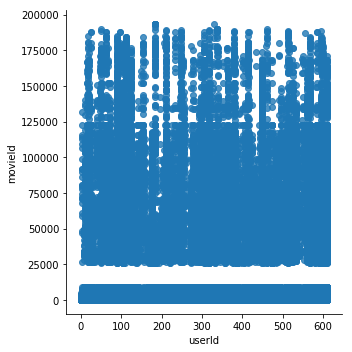

In [21]:


import seaborn as sns
%matplotlib inline

ratingsPandas = ratings.toPandas()
sns.lmplot(x='userId', y='movieId', data=ratingsPandas, fit_reg=False)



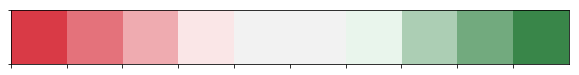

In [22]:
sns.palplot(sns.diverging_palette(10, 133, sep=80, n=10))

/usr/local/lib/python3.5/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


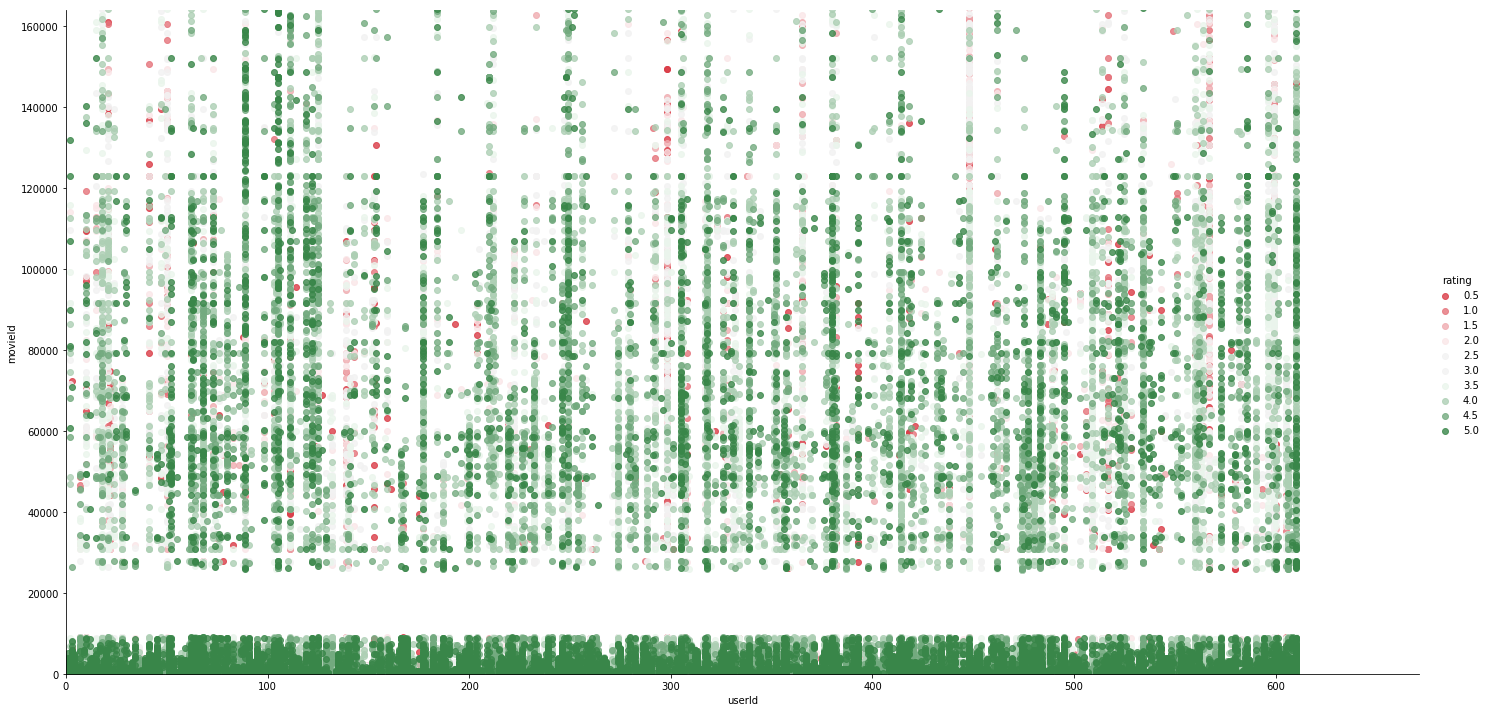

In [23]:


lm = sns.lmplot(x='userId', y='movieId', hue='rating', data=ratingsPandas, fit_reg=False, size=10, aspect=2, palette=sns.diverging_palette(10, 133, sep=80, n=10))
axes = lm.axes
axes[0,0].set_ylim(0,163949) # max movieId is 163949
axes[0,0].set_xlim(0,671) # max userId is 671
lm



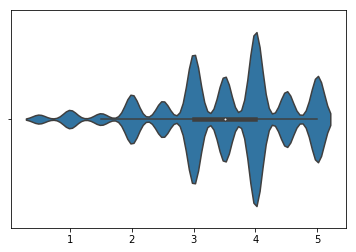

In [24]:
sns.violinplot([ratingsPandas.rating])

In [25]:


spark.sql("""
    SELECT *, 100 * nb_ratings/matrix_size AS percentage
    FROM (
        SELECT nb_users, nb_movies, nb_ratings, nb_users * nb_movies AS matrix_size
        FROM (
            SELECT COUNT(*) AS nb_ratings, COUNT(DISTINCT(movieId)) AS nb_movies, COUNT(DISTINCT(userId)) AS nb_users
            FROM ratings
        )
    )
""").show()



+--------+---------+----------+-----------+------------------+
|nb_users|nb_movies|nb_ratings|matrix_size|        percentage|
+--------+---------+----------+-----------+------------------+
|     610|     9724|    100836|    5931640|1.6999683055613624|
+--------+---------+----------+-----------+------------------+



In [26]:
from pyspark.ml.recommendation import ALS

model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating").fit(ratings)

In [27]:
predictions = model.transform(ratings)
predictions.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   191|    148|   5.0| 829760897| 4.9210477|
|   133|    471|   4.0| 843491793| 3.2373154|
|   597|    471|   2.0| 941558175| 3.8018956|
|   385|    471|   4.0| 850766697| 3.2501628|
|   436|    471|   3.0| 833530187| 3.6024926|
|   602|    471|   4.0| 840876085| 3.4134116|
|    91|    471|   1.0|1112713817| 2.3859527|
|   409|    471|   3.0| 967912821| 3.4231648|
|   372|    471|   3.0| 874415126| 3.0773392|
|   599|    471|   2.5|1498518822| 2.5675955|
|   603|    471|   4.0| 954482443| 2.6910934|
|   182|    471|   4.5|1054779644| 4.0634227|
|   218|    471|   4.0|1111624874| 3.4953947|
|   474|    471|   3.0| 974668858| 3.4761868|
|   500|    471|   1.0|1005528017| 2.2125888|
|    57|    471|   3.0| 969753604| 3.6430998|
|   462|    471|   2.5|1123890831| 2.4415278|
|   387|    471|   3.0|1139047519|  3.169063|
|   610|    471|   4.0|1479544381|

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
print ("The root mean squared error for our model is: " + str(evaluator.evaluate(predictions)))

The root mean squared error for our model is: 0.5929992557023708


In [30]:


(trainingRatings, testRatings) = ratings.randomSplit([80.0, 20.0])



In [31]:


als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating")
model = als.fit(trainingRatings)
predictions = model.transform(testRatings)



In [32]:
predictions.show()


+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   385|    471|   4.0| 850766697| 3.1117651|
|   372|    471|   3.0| 874415126| 2.6765206|
|   182|    471|   4.5|1054779644|  4.169965|
|    57|    471|   3.0| 969753604| 3.5051637|
|   387|    471|   3.0|1139047519| 3.2653742|
|   217|    471|   2.0| 955943727| 2.5109613|
|   273|    471|   5.0| 835861348| 4.4500937|
|   426|    471|   5.0|1451081135| 3.8063712|
|   169|   1088|   4.5|1059427717|  4.332521|
|   479|   1088|   4.0|1039362157| 3.1742718|
|    41|   1088|   1.5|1458939142|  2.721863|
|   555|   1088|   4.0| 978822670| 3.0283809|
|    51|   1088|   4.0|1230929736| 3.7445922|
|   391|   1088|   1.0|1030824424|  2.941335|
|   385|   1238|   3.0| 865026050|  4.050043|
|   325|   1238|   4.0|1039399025| 4.4835806|
|    19|   1238|   3.0| 965705784|  3.595903|
|   503|   1342|   1.0|1335214611| 2.9174976|
|   600|   1342|   2.5|1237851755|

In [33]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
print ("The root mean squared error for our model is: " + str(evaluator.evaluate(predictions)))

The root mean squared error for our model is: nan


In [36]:
avgRatings = ratings.select('rating').groupBy().avg().first()[0]
print ("The average rating in the dataset is: " + str(avgRatings))

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
print ("The root mean squared error for our model is: " + str(evaluator.evaluate(predictions.na.fill(avgRatings))))

The average rating in the dataset is: 3.501556983616962
The root mean squared error for our model is: 0.8852200766972289


In [37]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
print ("The root mean squared error for our model is: " + str(evaluator.evaluate(predictions.na.drop())))

The root mean squared error for our model is: 0.8738353342603052


In [39]:
def repeatALS(data, k=3, userCol="userId", itemCol="movieId", ratingCol="rating", metricName="rmse"):
    evaluations = []
    for i in range(0, k):  
        (trainingSet, testingSet) = data.randomSplit([k-1.0, 1.0])
        als = ALS(userCol=userCol, itemCol=itemCol, ratingCol=ratingCol)
        model = als.fit(trainingSet)
        predictions = model.transform(testingSet)
        evaluator = RegressionEvaluator(metricName=metricName, labelCol="rating", predictionCol="prediction")
        evaluation = evaluator.evaluate(predictions.na.drop())
        print ("Loop " + str(i+1) + ": " + metricName + " = " + str(evaluation))
        evaluations.append(evaluation)
    return sum(evaluations)/float(len(evaluations))



In [41]:
print ("RMSE = " + str(repeatALS(ratings, k=4)))

Loop 1: rmse = 0.8902180274607108
Loop 2: rmse = 0.8892741509634199
Loop 3: rmse = 0.8870180547076699
Loop 4: rmse = 0.887975546450938
RMSE = 0.8886214448956846


In [43]:

def kfoldALS(data, k=3, userCol="userId", itemCol="movieId", ratingCol="rating", metricName="rmse"):
    evaluations = []
    weights = [1.0] * k
    splits = data.randomSplit(weights)
    for i in range(0, k):  
        testingSet = splits[i]
        trainingSet = spark.createDataFrame(sc.emptyRDD(), data.schema)
        for j in range(0, k):
            if i == j:
                continue
            else:
                trainingSet = trainingSet.union(splits[j])
        als = ALS(userCol=userCol, itemCol=itemCol, ratingCol=ratingCol)
        model = als.fit(trainingSet)
        predictions = model.transform(testingSet)
        evaluator = RegressionEvaluator(metricName=metricName, labelCol="rating", predictionCol="prediction")
        evaluation = evaluator.evaluate(predictions.na.drop())
        print ("Loop " + str(i+1) + ": " + metricName + " = " + str(evaluation))
        evaluations.append(evaluation)
    return sum(evaluations)/float(len(evaluations))



In [45]:
print ("RMSE = " + str(kfoldALS(ratings, k=4)))

Loop 1: rmse = 0.8934047840459733
Loop 2: rmse = 0.8846554264288211
Loop 3: rmse = 0.8784957386410154
Loop 4: rmse = 0.891143836605747
RMSE = 0.8869249464303892


In [47]:
print ("RMSE = " + str(kfoldALS(ratings, k=10)))

Loop 1: rmse = 0.8622404608279335
Loop 2: rmse = 0.8651886237637294
Loop 3: rmse = 0.8761782765507801
Loop 4: rmse = 0.8614151725411524
Loop 5: rmse = 0.8779603975763991
Loop 6: rmse = 0.8730588787717687
Loop 7: rmse = 0.8751528466759392
Loop 8: rmse = 0.8762666296290537
Loop 9: rmse = 0.8712941287238982
Loop 10: rmse = 0.8619727665124858
RMSE = 0.8700728181573141


In [50]:
from pyspark.sql.functions import lit

def recommendMovies(model, user, nbRecommendations):
    # Create a Spark DataFrame with the specified user and all the movies listed in the ratings DataFrame
    dataSet = ratings.select("movieId").distinct().withColumn("userId", lit(user))

    # Create a Spark DataFrame with the movies that have already been rated by this user
    moviesAlreadyRated = ratings.filter(ratings.userId == user).select("movieId", "userId")

    # Apply the recommender system to the data set without the already rated movies to predict ratings
    predictions = model.transform(dataSet.subtract(moviesAlreadyRated)).dropna().orderBy("prediction", ascending=False).limit(nbRecommendations).select("movieId", "prediction")

    # Join with the movies DataFrame to get the movies titles and genres
    recommendations = predictions.join(movies, predictions.movieId == movies.movieId).select(predictions.movieId, movies.title, movies.genres, predictions.prediction)

    recommendations.show(truncate=False)

In [52]:
print ("Recommendations for user 133:")
recommendMovies(model, 133, 10)
print ("Recommendations for user 471:")
recommendMovies(model, 471, 10)
print ("Recommendations for user 496:")
recommendMovies(model, 496, 10)

Recommendations for user 133:
+-------+-----------------------------------------------------------------------------------------------------------------------------+--------------------------+----------+
|movieId|title                                                                                                                        |genres                    |prediction|
+-------+-----------------------------------------------------------------------------------------------------------------------------+--------------------------+----------+
|720    |Wallace & Gromit: The Best of Aardman Animation (1996)                                                                       |Adventure|Animation|Comedy|3.8425586 |
|3379   |On the Beach (1959)                                                                                                          |Drama                     |3.8442771 |
|6201   |Lady Jane (1986)                                                                           